# **Imports**

In [ ]:
import xml.etree.ElementTree as elemT
import re
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
from nltk.corpus import stopwords as sw
from nltk.tokenize import TreebankWordTokenizer as twt
import spacy
from google.colab import files
from google.colab import drive
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

nltk.download("stopwords")
# !python -m spacy download fr

drive.mount("/content/gdrive", force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Mounted at /content/gdrive


# **Dataframe creation**

In [ ]:
def CreateDataFrame(fileCSV):
    tree = elemT.parse("gdrive/My Drive/Colab Notebooks/Adv. Machine Learning/" + fileCSV)
    root = tree.getroot()

    allText = []

    for child in root:
        corpus = ""
        title = ""
        date = ""
        abstract = ""
        keyword = ""

        if child.get("{http://www.w3.org/XML/1998/namespace}lang") == "fr":
            title = GetRidOfLineBreak(str(child[0][0][0][0].text).lower())
            date = GetRidOfLineBreak(str(child[0][0][1][2].text).lower())
            abstract = GetRidOfLineBreak(str(child[1][0][0][0].text).lower())
            keyword = GetRidOfLineBreak(str(child[1][0][2][0].text).lower())
            for i in range(len(child[1][1])):
                for j in range(len(child[1][1][i])):
                    if len(child[1][1][i]) > 1:
                        for k in range(len(child[1][1][i][j])):
                            tempTxt = GetRidOfLineBreak(str(child[1][1][i][j][k].text).lower() + " ")
                            corpus = corpus + tempTxt
                    else:
                        tempTxt = GetRidOfLineBreak(str(child[1][1][i][j].text).lower() + " ")
                        corpus = corpus + tempTxt
            allText.append([title, date, abstract, corpus, keyword])
        
    df = pd.DataFrame(allText,columns=["Title", "Date", "Abstract", "Corpus", "Keyword"])
    return df

def GetRidOfLineBreak(string):
    regex = re.compile(r'[\n\r\t]')
    return regex.sub(" ", string)

df = CreateDataFrame("corpus_taln_v1.tei.xml")

In [ ]:
df.head()

,Title,Date,Abstract,Corpus,Keyword
0,éléments de conception d'un système d'interpr...,1997,nous considérons dans notre travail la tâche ...,les étapes de l'analyse l'analyse linguisti...,none
1,informatisation du dictionnaire explicatif et...,1997,nous donnons ici un aperçu du logiciel decid ...,objectifs le projet nadia-dec est basé sur ...,none
2,construction d'une représentation sémantique ...,1997,diverses méthodes ont été proposées pour cons...,,none
3,systèmes de types pour la (lambda-)drt ascend...,1998,le terme de lambda-drt désigne un ensemble de...,représentation du discours représentation s...,none
4,une grammaire tag vue comme une grammaire sen...,1998,"dans cet article, nous comparons deux modèles...",les différents niveaux de représentation en t...,none


# **Preprocessing**

In [ ]:
def GetRidOfApostrophe(df, column):
    replacements = (("d\'", "de "), ("qu\'", "que "), ("l\'", "le "), ("j\'", "je "), ("c\'", "ce "), ("s\'", "se "), ("n\'", "ne "), ("m\'", "me "), ("t\'", "te "))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

def GetRidOfSpecialCharacter(df, column):
    df[column] = df[column].str.replace('[\-\[\]+;\'!\^:/,"#&@\(\)\$\?%\_\*«»]|[A-Z]\.|None|', "")

def GetRidOfAccent(df, column):
    replacements = (("[éèê]", "e"), ("[à]", "a"), ("[ù]", "u"), ("[ï]", "i"), ("[ö]", "o"))
    for replacement in replacements:
        df[column] = df[column].str.replace(*replacement)

In [ ]:
def Preprocessing(df):
    columns = ["Title", "Date", "Abstract", "Corpus", "Keyword"]
    for column in columns:
        GetRidOfApostrophe(df, column)
        GetRidOfSpecialCharacter(df, column)
        GetRidOfAccent(df, column)

Preprocessing(df)

In [ ]:
df.head()

,Title,Date,Abstract,Corpus,Keyword
0,elements de conception de un systeme de inter...,1997,nous considerons dans notre travail la tâche ...,les etapes de le analyse le analyse linguis...,none
1,informatisation du dictionnaire explicatif et...,1997,nous donnons ici un aperçu du logiciel decid ...,objectifs le projet nadiadec est base sur l...,none
2,construction de une representation semantique...,1997,diverses methodes ont ete proposees pour cons...,,none
3,systemes de types pour la lambdadrt ascendante,1998,le terme de lambdadrt designe un ensemble de ...,representation du discours representation s...,none
4,une grammaire tag vue comme une grammaire sen...,1998,dans cet article nous comparons deux modeles ...,les differents niveaux de representation en t...,none


In [ ]:
def UseStopWords(df):
    stopWords = sw.words("french")

    df["Title"] = df["Title"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    df["Abstract"] = df["Abstract"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    df["Corpus"] = df["Corpus"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))
    df["Keyword"] = df["Keyword"].apply(lambda i : ' '.join([word for word in i.split() if word not in stopWords]))

UseStopWords(df)

In [ ]:
df.head()

,Title,Date,Abstract,Corpus,Keyword
0,elements conception systeme interpretation aut...,1997,considerons travail tâche traitement automatiq...,etapes analyse analyse linguistique texte modu...,none
1,informatisation dictionnaire explicatif combin...,1997,donnons ici aperçu logiciel decid developpe ge...,objectifs projet nadiadec base travaux definit...,none
2,construction representation semantique graphes...,1997,diverses methodes ete proposees construire gra...,,none
3,systemes types lambdadrt ascendante,1998,terme lambdadrt designe ensemble methodes perm...,representation discours representation syntaxi...,none
4,grammaire tag vue comme grammaire senstexte pr...,1998,cet article comparons deux modeles linguistiqu...,differents niveaux representation tst cette et...,none


In [ ]:
nlp = spacy.load("fr")
columns = ["Title", "Abstract", "Corpus"]

for index, row in df.iterrows():
    for column in columns:
        doc = nlp(row[column])
        result = ""
        count = 0
        for token in doc:
          result = result + token.lemma_
          count = count + 1
          if count < len(doc)-1:
            result = result + " "
        row[column] = result

In [ ]:
df.head()

,Title,Date,Abstract,Corpus,Keyword
0,element conception system interpretation autom...,1997,consideron travail tâche traitement automatiqu...,etape analyse analyse linguistique texte modul...,none
1,informatisation dictionnair explicatifcombinat...,1997,donnon ici aperçu logiciel decid developpe get...,objectif projet nadiadec base traval definitio...,none
2,construction representation semantiqu graphe c...,1997,divers methode ete proposee construir graphe c...,,none
3,systeme type lambdadrtascendant,1998,terme lambdadrt designe ensembl methodes perme...,representation discour representation syntaxiq...,none
4,grammair tag vue comme grammaire senstexteprec...,1998,ce article comparon deux modele linguistique u...,different niveal representation tst ce etude c...,none


In [ ]:
# Test du lemmatizer, on remarque qu'il ne fait pas toujours la différence sur certains mots
nlp = spacy.load("fr")

doc = nlp("considérons")
for token in doc:
    print(token, token.lemma_)

considérons considéron


# **Analyse**

NUAGE DE MOTS

Nous proposons d'analyser les nuages de mots de chaque Abstract trié par année afin de voir l'évolution des thèmes au fil du temps.

In [ ]:
df.sort_values(by="Date", ascending=True)

,Title,Date,Abstract,Corpus,Keyword
0,elements conception systeme interpretation aut...,1997,considerons travail tâche traitement automatiq...,etapes analyse analyse linguistique texte modu...,none
1,informatisation dictionnaire explicatif combin...,1997,donnons ici aperçu logiciel decid developpe ge...,objectifs projet nadiadec base travaux definit...,none
2,construction representation semantique graphes...,1997,diverses methodes ete proposees construire gra...,,none
15,formalisme deplacement,1998,traitement semantique spatialite necessite man...,chemin chemin couple i iab intervalle partie c...,none
14,conception implementation indexation balem bas...,1998,domaine ingenierie linguistique connaissance p...,solution mise oeuvre exemple fichier edition d...,none
...,...,...,...,...,...
1477,exploration apprentissage transfert analyse te...,2019,apprentissage transfert represente capacite mo...,schema adaptation domaines finetuning. descrip...,apprentissage transfert contenus reseaux socia...
1478,explorer informativite phrase,2019,presentons ici exploration preliminaire concep...,examples of informativeness disparity between ...,informativite plongements mots classification ...
1479,hybridation agent conversationnel plongementsl...,2019,contexte medical patient medecin virtuel dialo...,architecture interaction apprenantagent descri...,agents conversationnels chatbots medecine form...
1472,detecter nonadherence medicamenteuse forums di...,2019,methodes recherche information permettent expl...,corpus donnees reference corpus constitue mess...,recherche information requetes forums nonadher...


In [ ]:
def MakeWordCloud(corpus):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

1997


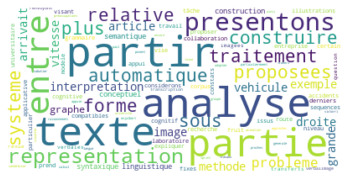

1998


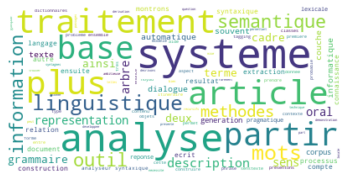

1999


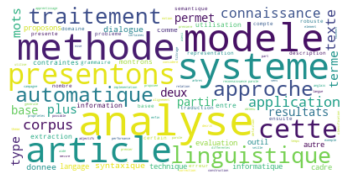

2000


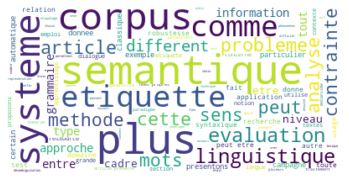

2001


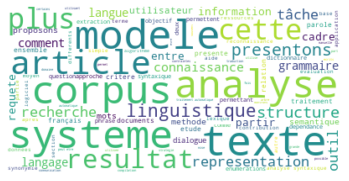

2002


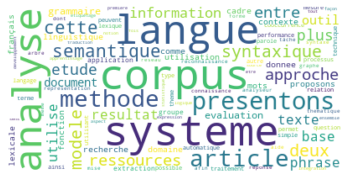

2003


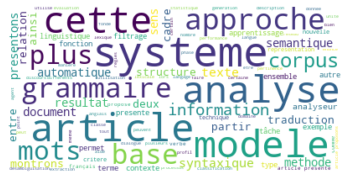

2004


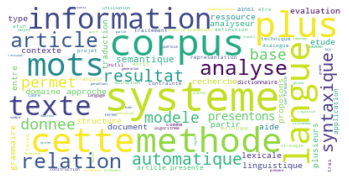

2005


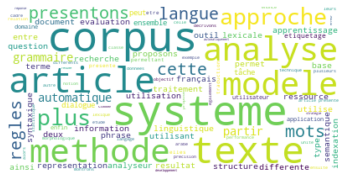

2006


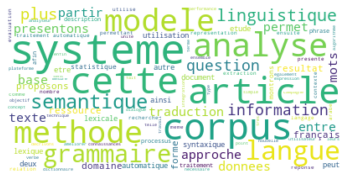

2007


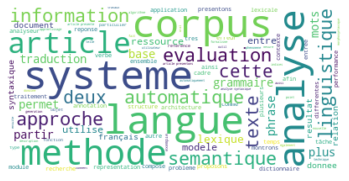

2008


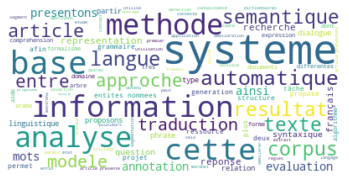

2009


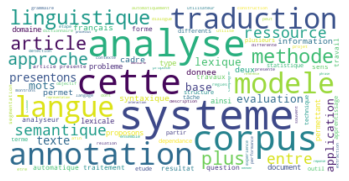

2010


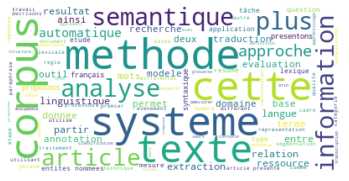

2011


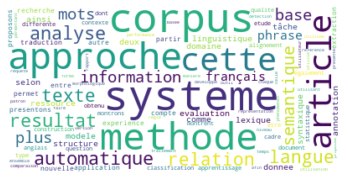

2012


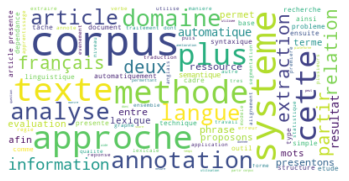

2013


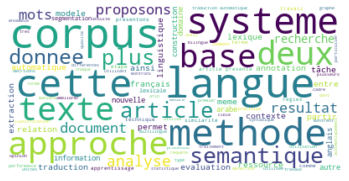

2014


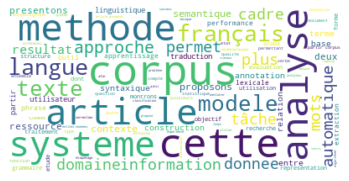

2015


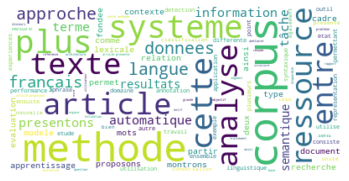

2016


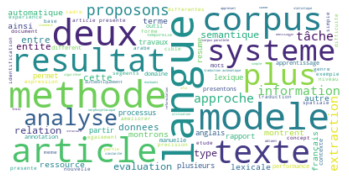

2017


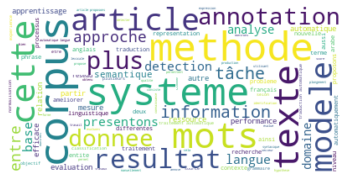

2018


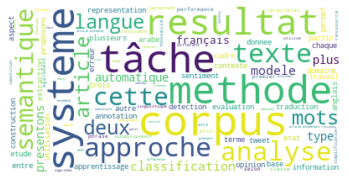

In [ ]:
dateMemory = df.iloc[0]["Date"]
corpus = ""

for index, row in df.iterrows():
    if row["Date"] == dateMemory:
        corpus = corpus + row["Abstract"]
    else:
        print(dateMemory)
        MakeWordCloud(corpus)
        dateMemory = row["Date"]
        corpus = row["Abstract"]

Diagramme en barre

In [ ]:
def ShowMostCommonWords(countData, countVectorizer):
    words = countVectorizer.get_feature_names()
    totalCounts = np.zeros(len(words))
    for data in countData:
        totalCounts += data.toarray()[0]
    
    countDictionary = (zip(words, totalCounts))
    countDictionary = sorted(countDictionary, key = lambda x : x[1], reverse = True)[0:10]
    words = [w[0] for w in countDictionary]
    counts = [w[1] for w in countDictionary]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize = (15, 15/1.6180))
    plt.subplot(title='Les 10 mots les plus récurrents')
    sb.set_context("notebook", font_scale = 1.25, rc = {"lines.linewidth": 1})
    sb.barplot(x_pos, counts, palette = 'pastel') # Couleur des barres
    plt.xticks(x_pos, words, rotation = 45) # Rotation de la légende
    plt.xlabel('Mots')
    plt.ylabel('Occurrence')
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


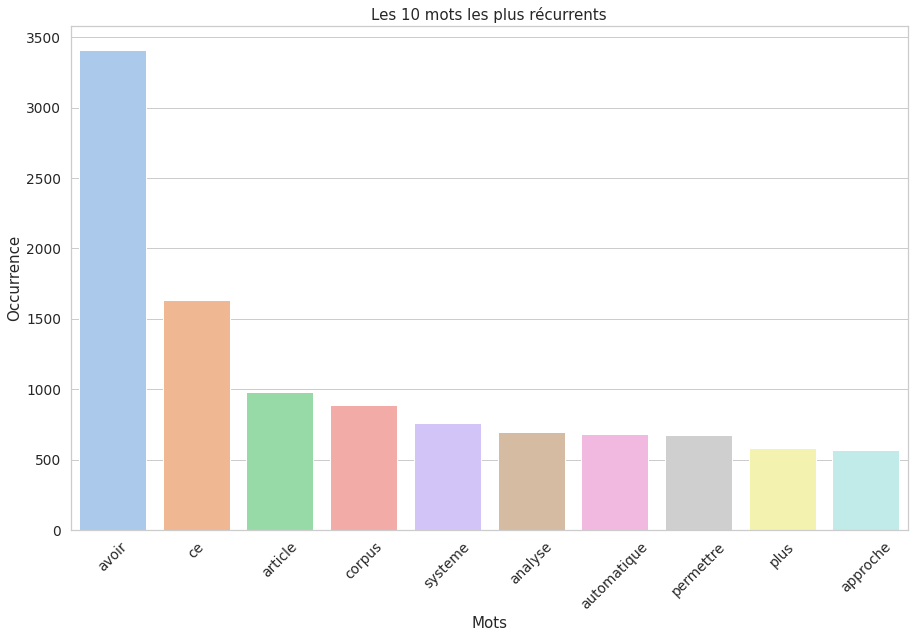

In [ ]:
sb.set_style('whitegrid')
stopWords = sw.words("french")

countVectorizer = CountVectorizer(stopWords)
countData = countVectorizer.fit_transform(df["Abstract"])
ShowMostCommonWords(countData, countVectorizer)

NUAGE DE MOTS ET DIAGRAMME EN BARRE AMELIORE

In [ ]:
# Pour obtenir les résultats présentés dans le rapport, nous avons réutilisé les lignes de codes précédentes.
# Premièrement, nous avons récrée le dataframe à partir du fichier d'origine.
# Ensuite, nous avons effectuer toutes les étapes de préprocessing SAUF la partie utilisant le lemmatizer.
# Enfin, nous utilisons le code suivant afin de supprimer tous les mots de 3 lettres ou moins dans le dataframe.

def GetRidOfThreeWords(df):
    columns = ["Title", "Abstract", "Corpus"]
    for column in columns:
        df[column] = df[column].str.replace(r'\b\w{1,3}\b', "")

GetRidOfThreeWords(df)

In [ ]:
df.head()

,Title,Date,Abstract,Corpus,Keyword
0,elements conception systeme interpretation aut...,1997,considerons travail tâche traitement automatiq...,etapes analyse analyse linguistique texte modu...,none
1,informatisation dictionnaire explicatif combin...,1997,donnons aperçu logiciel decid developpe geta ...,objectifs projet nadiadec base travaux definit...,none
2,construction representation semantique graphes...,1997,diverses methodes proposees construire graphe...,,none
3,systemes types lambdadrt ascendante,1998,terme lambdadrt designe ensemble methodes perm...,representation discours representation syntaxi...,none
4,grammaire comme grammaire senstexte precompilee,1998,article comparons deux modeles linguistiques ...,differents niveaux representation cette etude...,none


LDA

In [ ]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nSujet #%d:" % (topic_idx+1))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
lda = LDA(n_components=5, n_jobs=-1) # n_components représente le nombre de sujets que l'on veut
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10) # la valeur représente le nombre de mots que l'on veut pour définir un sujet

Topics found via LDA:

Sujet #1:
mots sens entre cette relations plus corpus analyse article semantique

Sujet #2:
automatique corpus traduction cette article approche methode langue plus systeme

Sujet #3:
article corpus cette analyse entre deux plus mots resultats presentons

Sujet #4:
corpus systeme article analyse presentons automatique resultats français plus cette

Sujet #5:
corpus article presentons analyse cette textes plus evaluation systeme resultats
